# Model Analysis of best centralized learning attempt

In [14]:
import tensorflow as tf
import sys
sys.path.append("../")
from federated.data.mitbih_data_preprocessing import load_data
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import itertools

In [15]:
import nest_asyncio
nest_asyncio.apply()

In [16]:
"""
Function that loads model and dataset for analysis
Returns x_test, y_test and model
"""
def load(name):
    model = tf.keras.models.load_model("../history/logdir/" + name)
    X_test, y_test = load_data(data_analysis=True)

    X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
    X_test.shape
    return X_test, y_test, model

In [17]:
"""
Function that evaluates the model.
Prints accuracy and loss value
"""
def evaluation(X, y, model):
    scores = model.evaluate(X, y, verbose=0)
    print(f"Accuracy: {scores[1]*100}%, Loss: {scores[0]}")



In [18]:
"""
Function that creates confusion matrix based upon the dataset and the model
Displays the confusion matrix for the model.
"""

def make_confusion_matrix(X,y, model):
    y_pred = model.predict(X)
    y_test = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    cnf_matrix = confusion_matrix(y_test, y_pred)

    labels = ["N", "S", "V", " F", "U"]

    plt.figure(figsize=(15,15))
    cnf_matrix =  cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45)
    plt.yticks(ticks, labels)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j,i,format(cnf_matrix[i,j], '.2f'), horizontalalignment="center",
                    color="white" if cnf_matrix[i, j] > cnf_matrix.max()/2 else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


    plt.show()

## Loading model and test dataset for centralized

In [19]:
X_test, y_test, model_centralized = load("centralized_dense_v0")

## Evaluating model for centralized

In [20]:
evaluation(X_test,y_test,model_centralized)

Accuracy: 96.27717733383179%, Loss: 0.2311517298221588


## Confusion Matrix

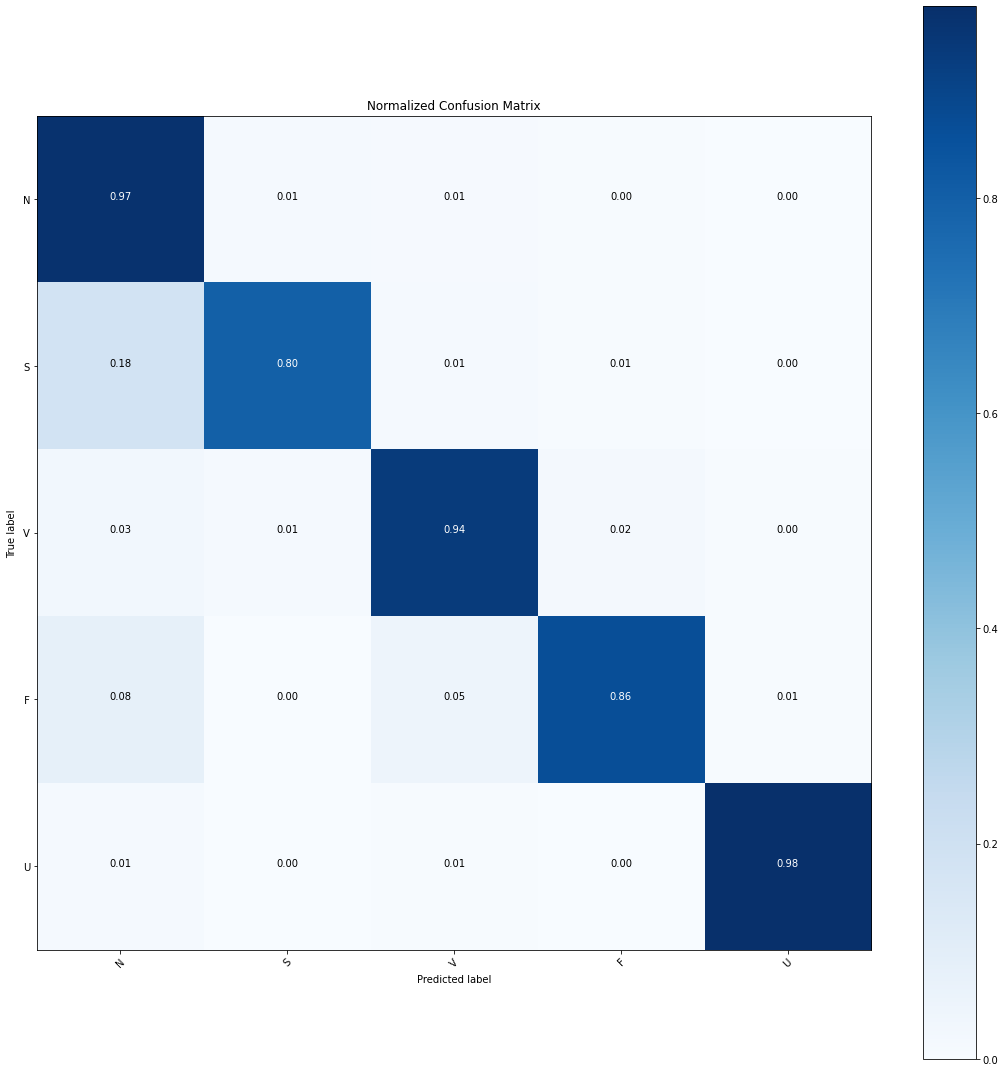

In [21]:
make_confusion_matrix(X_test, y_test, model_centralized)

## Loading dataset and model for federated learning

In [22]:
X_test, y_test, model_fed = load("FedSGD_normalized_nonIID_v0")

## Evaluating model for federated learning

In [23]:
evaluation(X_test, y_test, model_fed)

Accuracy: 65.04202485084534%, Loss: 1.0060189962387085


## Confusion Matrix for federated learning

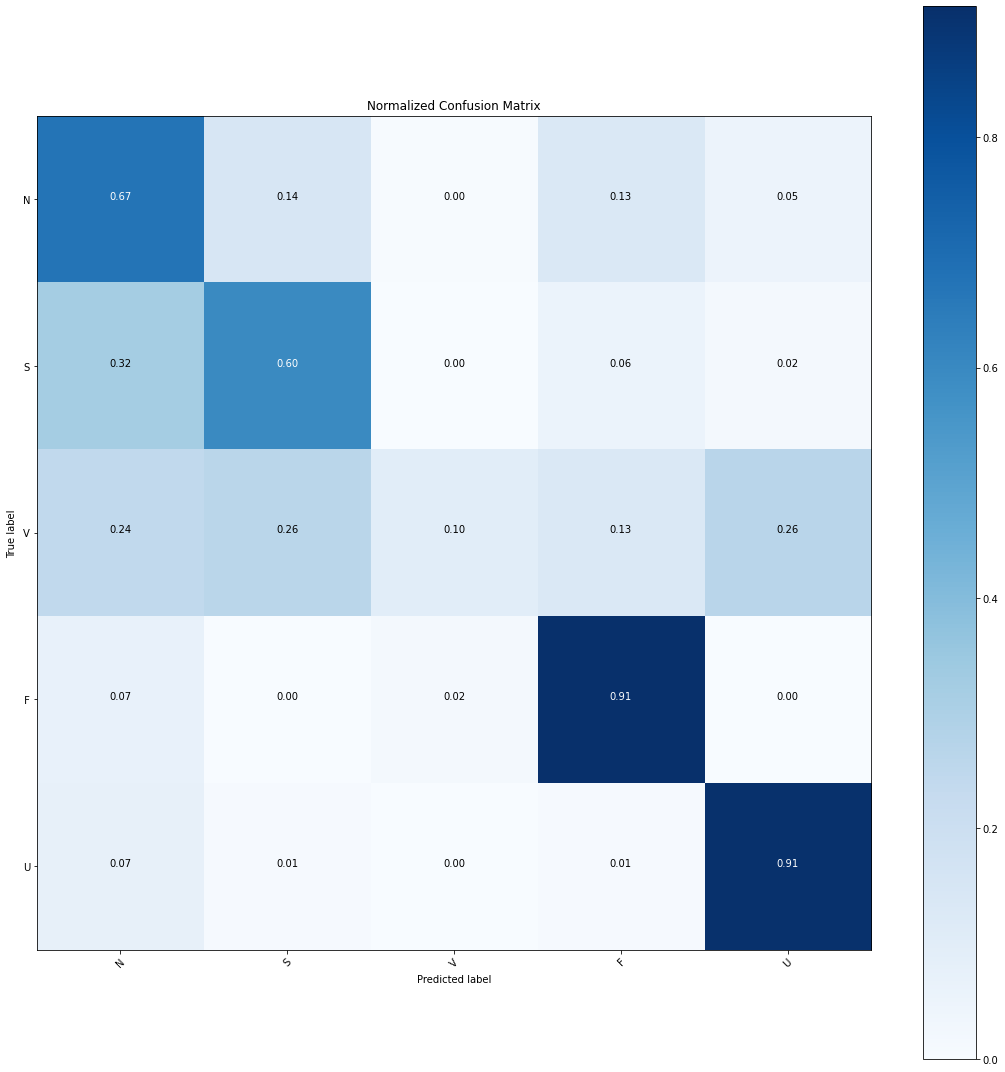

In [24]:
make_confusion_matrix(X_test, y_test, model_fed)

In [25]:
 X_test, y_test, model_fed = load("FedAVG_normalized_nonIID_v0")

In [26]:
evaluation(X_test, y_test, model_fed)

Accuracy: 93.64151358604431%, Loss: 0.273680716753006


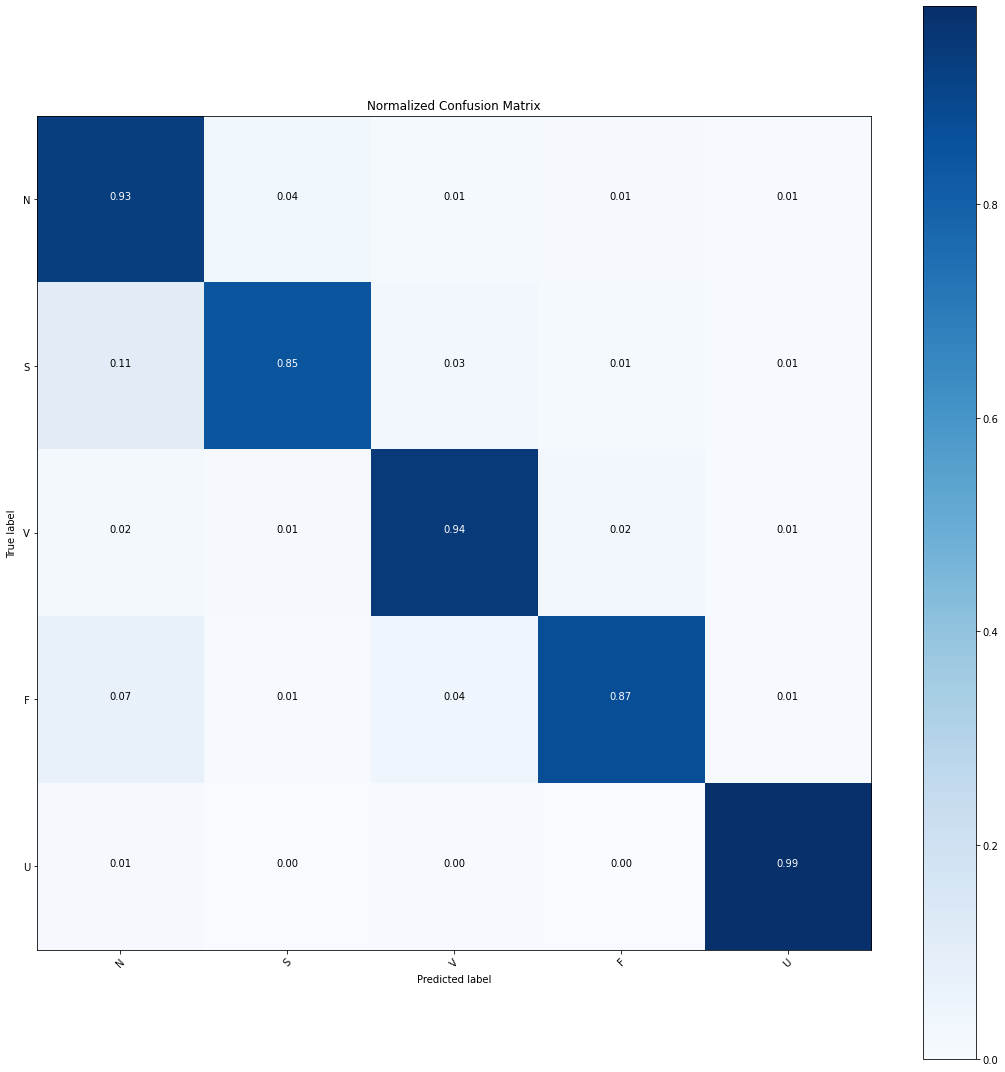

In [27]:
make_confusion_matrix(X_test, y_test, model_fed)